# Linking field data to imagery to update the Fractional Cover and Ground Cover Models
This is the workbook used to compute the new end-to-end fractional cover model


## Imports

In [2]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import datetime
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, regularizers
from tensorflow.keras.constraints import max_norm



print("TensorFlow v"+tf.__version__)
print(tf.test.gpu_device_name())



TensorFlow v2.3.0



## Read field and image data

All field data sits on postgres linked to ODK field data capture system.  
Need to first link view below the canopy to view above the canopy.  


In [68]:
CALIBRATION_DATA = '../fielddata/fractionalChips20181204.csv'

# Function to convert a date to a timestamp
def datestr2num(s):
    return (datetime.datetime.strptime(s,'%d/%m/%Y') - datetime.datetime(1970, 1, 1)).total_seconds()

# Function to get the sensor number (Landsat 5, 7 or 8) from a JRSRP filename
def sensorNum(s):
    return float(s[1])


interceptData = pd.read_csv(CALIBRATION_DATA,
                        na_values = "nan",
                        sep=",",
                        skipinitialspace=True).sample(frac=1)

# Add timestamp and sensor number to the dataframe
interceptData['fractional.obs_timestamp'] = interceptData['fractional.obs_time'].apply(datestr2num)
interceptData['fractional.obs_sensornum'] = interceptData['fractional_chips.filename'].apply(sensorNum)

# Load Reflectance Data fromthe closest point in time
refData = np.array(interceptData[['fractional_chips.b1_sf_mn',
       'fractional_chips.b2_sf_mn', 'fractional_chips.b3_sf_mn',
       'fractional_chips.b4_sf_mn', 'fractional_chips.b5_sf_mn',
       'fractional_chips.b6_sf_mn']]) / 10000.0

# Convert L8 to L7 so the model is in Landsat 7 spectral space
l8Idx=interceptData['fractional.obs_sensornum']>7
print ("There are %d Landsat 8 Scenes" % sum(l8Idx))

# Use the published coefficients to transform reflectance
refData[l8Idx] = refData[l8Idx] * (
    np.array([0.97470, 0.99779, 1.00446, 0.98906, 0.99467, 1.02551]) + 
    np.array([0.00041, 0.00289, 0.00274, 0.00004, 0.00256, -0.00327])
)

# Drop out the Blue Band
refData = refData[:,1:]


There are 1272 Landsat 8 Scenes


### Function to load the calibration data and return the satellite viewable components 

In [103]:
def fractionalCoverSatView(interceptData):
    nTotal = interceptData['fractional.num_points']
    nUnoccluded = interceptData['fractional.unoccluded']
    # Canopy Layer
    nCanopyBranch = interceptData['fractional.over_b'] * nTotal / 100.0
    nCanopyDead = interceptData['fractional.over_d'] * nTotal / 100.0
    nCanopyGreen = interceptData['fractional.over_g'] * nTotal / 100.0
    nCrown = interceptData['fractional.crn']
    # Midstory Layer
    nMidBranch = interceptData['fractional.mid_b'] * nTotal / 100.0
    nMidGreen = interceptData['fractional.mid_g'] * nTotal / 100.0
    nMidDead = interceptData['fractional.mid_d'] * nTotal / 100.0
    # Ground Layer
    nGroundDeadLitter = (interceptData['fractional.dead'] + interceptData['fractional.litter']) * nUnoccluded / 100.0
    nGroundCrustDistRock = (interceptData['fractional.crust'] + interceptData['fractional.dist'] + interceptData['fractional.rock']) * nUnoccluded / 100.0
    nGroundGreen = interceptData['fractional.green'] * nUnoccluded / 100.0
    nGroundCrypto = interceptData['fractional.crypto'] * nUnoccluded / 100.0
    # Work out the canopy elements as viewed from above
    canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
    canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
    canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
    canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
    # Work out the midstorey fractions
    midFoliageProjectiveCover = nMidGreen / nTotal
    midDeadProjectiveCover = nMidDead / nTotal
    midBranchProjectiveCover = nMidBranch / nTotal
    midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
    # Work out the midstorey  elements as viewed by the satellite using a gap fraction method
    satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidPlantProjectiveCover = midPlantProjectiveCover * (1 - canopyPlantProjectiveCover)
    # Work out the groundcover fractions as seen by the observer
    groundPVCover = nGroundGreen / nUnoccluded
    groundNPVCover = nGroundDeadLitter / nUnoccluded
    groundBareCover = nGroundCrustDistRock / nUnoccluded
    groundCryptoCover = nGroundCrypto / nUnoccluded
    groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nUnoccluded
    # Work out the ground cover propoetions as seen by the satellite
    satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundTotalCover = groundTotalCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    # Final total covers calculated using gap probabilities through all layers
    totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
    totalNPVCover = canopyDeadProjectiveCover + canopyBranchProjectiveCover + satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover
    totalBareCover = satGroundBareCover
    totalCryptoCover = satGroundCryptoCover
    # Work Out Persistent Fractions
    satPersistentGreen=canopyFoliageProjectiveCover+satMidFoliageProjectiveCover
    persistentNPVFraction=canopyDeadProjectiveCover+canopyBranchProjectiveCover+satMidDeadProjectiveCover+satMidBranchProjectiveCover

    return (totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction)
    
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction = fractionalCoverSatView(interceptData)

print  ("Number of sites: %d" % len(fractionalCoverArray))



Number of sites: 4000


## Equal Sampling Weighting
Because the samples are not uniformly distributed across the cover space, we set up a histogram based weighting function to make sure those rare sites still contribute to the model.

[2.155449106780262, -2.406622427482804, 0.7902358332069593, -0.031083924777037687]
[0.204346874326629, 0.038076938300460314, 0.06323932496133852, 0.004888470545678801]
[-0.28054264437493376, 0.95998274732822, -0.7306088295564968, 0.21589513407988004]


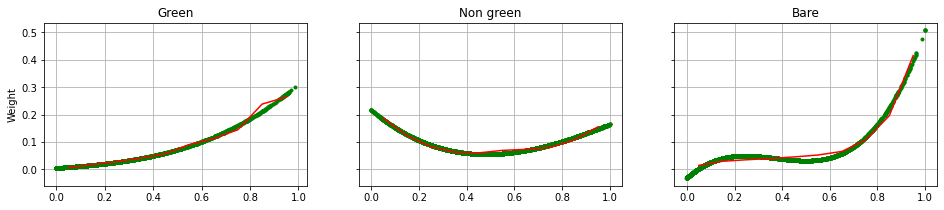

In [104]:
# Weighting by number of points
histoB = np.histogram(totalBareCover,bins=10,range=[0,1])
histoNormB=histoB[0].sum()/histoB[0]
histoNormB /= histoNormB.sum()
bareCoeffs = np.polyfit((histoB[1][1:]+histoB[1][:-1])/2,histoNormB,3)
print(list(bareCoeffs))
bareWeights = np.polyval(bareCoeffs,totalBareCover)

# Weighting by number of points
histoG = np.histogram(totalPVCover,bins=10,range=[0,1])
histoNormG=histoG[0].sum()/histoG[0]
histoNormG /= histoNormG.sum()
greenCoeffs = np.polyfit((histoG[1][1:]+histoG[1][:-1])/2,histoNormG,3)
print(list(greenCoeffs))
greenWeights = np.polyval(greenCoeffs,totalPVCover)

# Weighting by number of points
histoN = np.histogram(totalNPVCover,bins=10,range=[0,1])
histoNormN=histoN[0].sum()/histoN[0]
histoNormN /= histoNormN.sum()
nonGreenCoeffs = np.polyfit((histoN[1][1:]+histoN[1][:-1])/2,histoNormN,3)
print(list(nonGreenCoeffs))
nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)

sampleWeights = np.transpose([bareWeights,greenWeights,nonGreenWeights])

# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,3),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,greenWeights,'g.',(histoG[1][1:]+histoG[1][:-1])/2,histoNormG, 'r-')
ax2.plot(totalNPVCover,nonGreenWeights,'g.',(histoN[1][1:]+histoN[1][:-1])/2,histoNormN, 'r-')
ax3.plot(totalBareCover,bareWeights,'g.',(histoB[1][1:]+histoB[1][:-1])/2,histoNormB, 'r-')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_ylabel('Weight')
plt.savefig('weights.png', bbox_inches='tight')

## Build a weighted Loss Function



In [105]:
def histogramWeightedLoss(y_true, y_pred):

    yWeights = tf.transpose([
        tf.math.polyval([2.155449106780262, -2.406622427482804, 0.7902358332069593, -0.031083924777037687], y_true[:,0]),
        tf.math.polyval([0.204346874326629, 0.038076938300460314, 0.06323932496133852, 0.004888470545678801], y_true[:,1]),
        tf.math.polyval([-0.28054264437493376, 0.95998274732822, -0.7306088295564968, 0.21589513407988004], y_true[:,2])
    ])
   
    unmixingError = K.mean(K.abs(y_true * yWeights - y_pred * yWeights),axis=-1)
    negativityError =  K.mean(-y_pred * K.cast(K.less(y_pred,0), K.floatx()),axis=1)
    sum2oneError =  0.005 * K.abs(K.sum(y_pred,axis=1)-1.0)

    loss = unmixingError + sum2oneError + negativityError 
    
    return loss

## Build the Keras Network

In [107]:
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()


model = keras.Sequential([
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[train_dataset.shape[1]]),
layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(3)
])

model.compile(loss=histogramWeightedLoss,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['mean_absolute_error', 'mean_squared_error']) #'huber_loss'

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 771       
Total params: 35,395
Trainable params: 35,395
Non-trainable params: 0
_________________________________________________________________


## Train the model
Note we set up a couple of callbacks to display progress and stop after a while

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................................

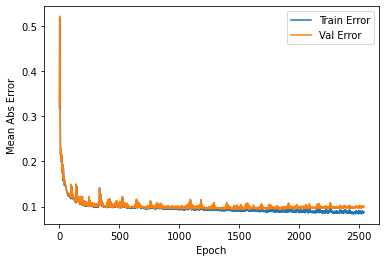

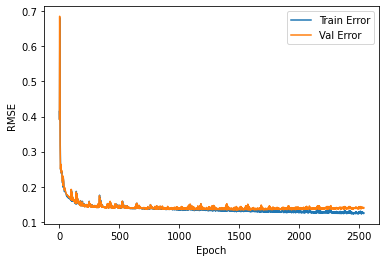

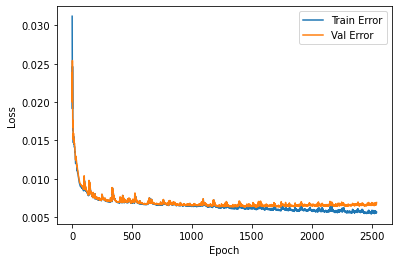

In [108]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# Fit the Model np.hstack((full_labels,sampleWeights))
history = model.fit(train_dataset, train_labels,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=4096,
                    callbacks=[early_stop,PrintDot()])
print('\n')

# Display the training history
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.plot(hist['epoch'], np.sqrt(hist['mean_squared_error']),label='Train Error')
  plt.plot(hist['epoch'], np.sqrt(hist['val_mean_squared_error']),label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [93]:
# Save the model
modelName = 'fcModel_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.hd5'
model.save(modelName,save_format='h5')
# Save a TFLite version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open(modelName.replace('hd5','tflite'), "wb").write(tflite_model)

print('Saved: ',modelName)




#loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)




Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\scart\DOCUME~1\MobaXterm\slash\var\log\xwin\tmpy2xc0m4d\assets
Saved:  fcModel_202105171156.hd5


## Iteration 1 - Minimal Prediction to assign crypto and pick up color errors
The next problem to address is field labeling issues.  
First, cryptogram (or biological soil crusts) are not assigned a "colour" and we need to decide whether to treat them as green or non green. We do this by doing a rough model fit, and then testing where the cryptogram component for each sit best fits.  
There is also an observer bias issue, where in areas of "yellow" grass people will pick non-green or green for the entire site. We check for this by looking for sites with a good bare fit but with a large and opposite error term for the green and non-green. By iterativly adjusting the field estimates across classes we gradually improve the bare estimate.  

Green RMSE = 0.097503
Non Green RMSE = 0.158703
Bare RMSE = 0.133988
Min Bare = 0.048187
Min Green = 0.014242
Min NonGreen = 0.046564


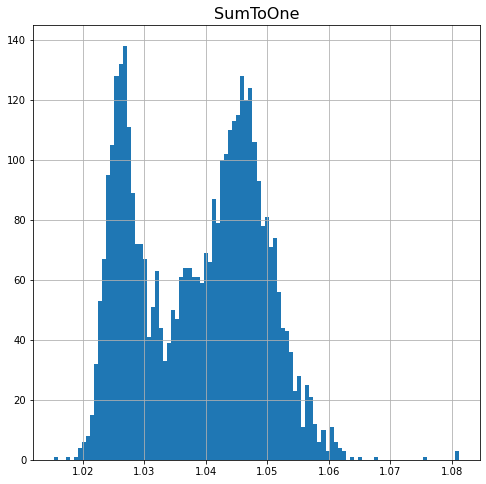

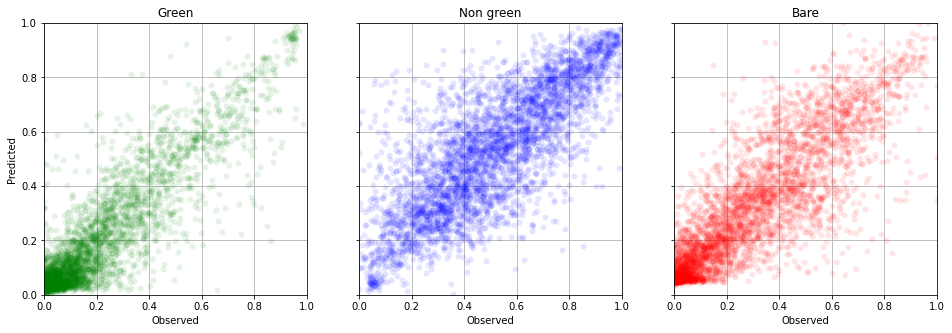

In [109]:
# Predict!
#test_predictions = model.predict(normed_test_data)
allLabels = train_labels
allPredictions = model.predict(train_dataset)

predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]
totalSum = predNongreenCover+predGreenCover+predBareCover

# Print some RMSE values
print( "Green RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % np.sqrt(np.mean((totalBareCover-predBareCover)**2)))
print( "Min Bare = %f" % np.percentile(predBareCover,1))
print( "Min Green = %f" % np.percentile(predGreenCover,1))
print( "Min NonGreen = %f" % np.percentile(predNongreenCover,1))


# Setup the sum to one histogram
fig = plt.figure(figsize=(8,8))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=16)
plt.grid(True)
plt.savefig('fcSum2one.png', bbox_inches='tight')

# Initialise the 1 row 3 column plot for each fraction
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.1,markeredgewidth=0.0)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.1,markeredgewidth=0.0)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.1,markeredgewidth=0.0)
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_xlabel('Observed')
ax2.set_xlabel('Observed')
ax3.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
f.savefig('fcCalibration.png', bbox_inches='tight')



### Fix the errors and assign the crypto
Once we have candidate models built we can check for mislabeled fractions and then assign the cryptogram.  
Note that is's only 10 or so sites that need cover label  repair.  

In [12]:
predGreenCover,predNongreenCover,totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights=dill.load(open( 'fcDump1.dat', "rb" ))


# Assign the crypto to the class that improves the error the most    
greenError  = predGreenCover - totalPVCover
nongreenError = predNongreenCover-totalNPVCover

cryptoNongreenIDX = (numpy.abs(nongreenError) >= numpy.abs(nongreenError-totalCryptoCover))
cryptoGreenIDX = (numpy.abs(nongreenError) < numpy.abs(nongreenError-totalCryptoCover))
totalPVCover[cryptoGreenIDX] = totalPVCover[cryptoGreenIDX] + totalCryptoCover[cryptoGreenIDX]
totalNPVCover[cryptoNongreenIDX] = totalNPVCover[cryptoNongreenIDX] + totalCryptoCover[cryptoNongreenIDX]


print("Nongreen crypto samples = %f" %numpy.sum(cryptoNongreenIDX))
print("Green crypto samples = %f" %numpy.sum(cryptoGreenIDX))





errorChange=1.0
error=10.0
siteList=[]

while error > 0.99:
    greenError  = predGreenCover - totalPVCover
    nongreenError = predNongreenCover-totalNPVCover
    bigOpposite = numpy.abs(greenError - nongreenError)
    bigIDX = numpy.argmax(bigOpposite)
    siteList.append(bigIDX)
    errorChange = error - bigOpposite[bigIDX]
    error = bigOpposite[bigIDX]
    print ("Max error = %f in site %d with total sites changed = %d" % (error,bigIDX,len(numpy.unique(siteList))))
    adjustment = (totalPVCover[bigIDX]+totalNPVCover[bigIDX])/100.0
    if  (greenError[bigIDX] > nongreenError[bigIDX]):
        totalNPVCover[bigIDX] = totalNPVCover[bigIDX] - numpy.min([adjustment,totalNPVCover[bigIDX]])
        totalPVCover[bigIDX] = totalPVCover[bigIDX] + numpy.min([adjustment,totalNPVCover[bigIDX]])

    else:
        totalPVCover[bigIDX] = totalPVCover[bigIDX] - numpy.min([adjustment,totalPVCover[bigIDX]])
        totalNPVCover[bigIDX] = totalNPVCover[bigIDX] + numpy.min([adjustment,totalPVCover[bigIDX]])

    

    
print("New green RMSE = %f" % numpy.sqrt(numpy.mean((totalPVCover-predGreenCover)**2)))
print("New nongreen RMSE = %f" % numpy.sqrt(numpy.mean((totalNPVCover-predNongreenCover)**2)))

numpy.unique(siteList)

Nongreen crypto samples = 3395.000000
Green crypto samples = 537.000000
Max error = 1.406137 in site 3112 with total sites changed = 1
Max error = 1.404376 in site 694 with total sites changed = 2
Max error = 1.389937 in site 3112 with total sites changed = 2
Max error = 1.384731 in site 694 with total sites changed = 2
Max error = 1.373737 in site 3112 with total sites changed = 2
Max error = 1.365086 in site 694 with total sites changed = 2
Max error = 1.357537 in site 3112 with total sites changed = 2
Max error = 1.345441 in site 694 with total sites changed = 2
Max error = 1.341337 in site 3112 with total sites changed = 2
Max error = 1.325796 in site 694 with total sites changed = 2
Max error = 1.325137 in site 3112 with total sites changed = 2
Max error = 1.308937 in site 3112 with total sites changed = 2
Max error = 1.306150 in site 694 with total sites changed = 2
Max error = 1.292737 in site 3112 with total sites changed = 2
Max error = 1.286505 in site 694 with total sites ch

array([ 331,  694, 2956, 3112, 3118, 3222, 3331], dtype=int64)

In [13]:
newFractionalCoverArray = np.transpose([totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction])


header = 'pv,npv,bare,crypto,pg,pnpv,b2,b3,b4,b5,b7,ndvi,burn,ndwi'
np.savetxt('fcData.csv',np.hstack((newFractionalCoverArray,refData)),delimiter=',',header=header,fmt='%.18f',comments='')

## Training for the three components
We build the three components individually and save the model forulation along the way.  

### Build the green model
Green is easiest to predict so we run that first.

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Green RMSE = 0.098327
Green R2 = 0.904131
CPU times: user 7.16 s, sys: 370 ms, total: 7.53 s
Wall time: 6min 13s


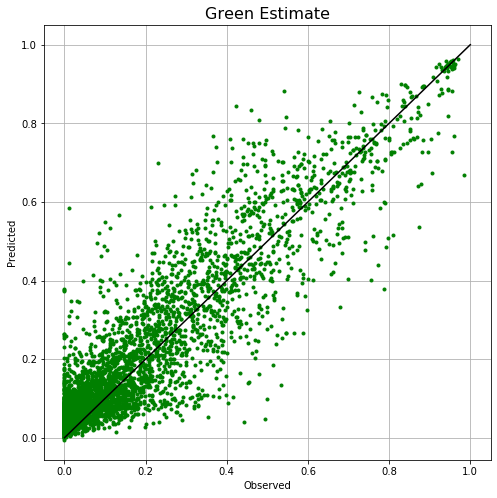

In [30]:
%%time

green_pipeline = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=cv,n_jobs=-1, scoring=scoring)
green_pipeline.fit(refData, logit(totalPVCover), sample_weight=greenWeights)
predGreenCover =  expit(green_pipeline.predict(refData))

print(green_pipeline.best_estimator_)
print( "Green RMSE = %f" % numpy.sqrt(numpy.mean((totalPVCover-predGreenCover)**2)))
print( "Green R2 = %f" % stats.pearsonr(totalPVCover,predGreenCover)[0])



# Setup the figure
fig = plt.figure(figsize=(8,8))
plt.plot(totalPVCover,predGreenCover, 'g.', [0,1], [0,1],'k-')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Green Estimate', fontsize=16)
plt.grid(True)


# Save Progress
dill.dump((totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights,predGreenCover),open( 'fcDump2.dat', "wb" ))


### Build the non-green model
We predict this second after the green but before the bare.  
Here we roll the green predictions into this model to improve the prediction.

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Non green RMSE = 0.139619
Non green R2 = 0.818287
CPU times: user 6.98 s, sys: 420 ms, total: 7.4 s
Wall time: 6min 33s


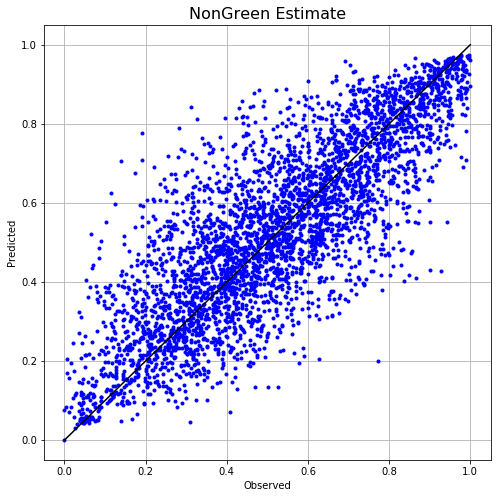

In [31]:
%%time

totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights, predGreenCover=dill.load(open( 'fcDump2.dat', "rb" ))

refData = numpy.append(refData,numpy.transpose([predGreenCover]),axis=1)


nongreen_pipeline = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=cv,n_jobs=-1, scoring=scoring)
nongreen_pipeline.fit(refData, logit(totalNPVCover), sample_weight=nonGreenWeights)
predNongreenCover =  expit(nongreen_pipeline.predict(refData))

print(nongreen_pipeline.best_estimator_)
print( "Non green RMSE = %f" % numpy.sqrt(numpy.mean((totalNPVCover-predNongreenCover)**2)))
print( "Non green R2 = %f" % stats.pearsonr(totalNPVCover,predNongreenCover)[0])


# Setup the figure
fig = plt.figure(figsize=(8,8))
plt.plot(totalNPVCover,predNongreenCover, 'b.', [0,1], [0,1],'k-')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('NonGreen Estimate', fontsize=16)
plt.grid(True)

# Save Progress
dill.dump((totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights,predGreenCover,predNongreenCover),open( 'fcDump3.dat', "wb" ))


### Build the bare model
Predict bare last as it's the most important one to get right.

SVR(C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Bare RMSE = 0.123556
Bare R2 = 0.818287
CPU times: user 7.8 s, sys: 460 ms, total: 8.26 s
Wall time: 9min 16s


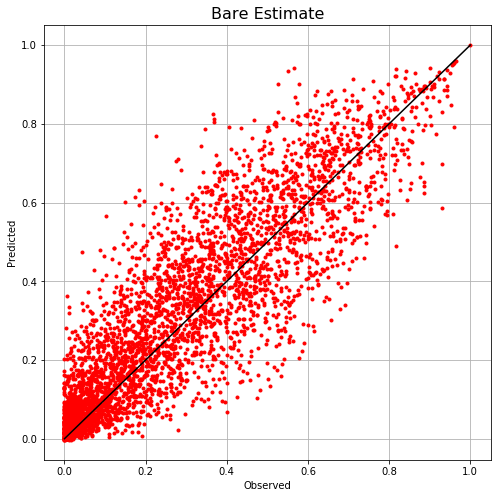

In [32]:
%%time

totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights,predGreenCover,predNongreenCover=dill.load(open( 'fcDump3.dat', "rb" ))
refData = numpy.append(refData,numpy.transpose([predNongreenCover]),axis=1)

bare_pipeline = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=cv,n_jobs=-1, scoring=scoring)
bare_pipeline.fit(refData, logit(totalBareCover), sample_weight=bareWeights)
predBareCover =  expit(bare_pipeline.predict(refData))

print(bare_pipeline.best_estimator_)
print( "Bare RMSE = %f" % numpy.sqrt(numpy.mean((totalBareCover-predBareCover)**2)))
print( "Bare R2 = %f" % stats.pearsonr(totalNPVCover,predNongreenCover)[0])


# Setup the figure
fig = plt.figure(figsize=(8,8))
plt.plot(totalBareCover,predBareCover, 'r.',[0,1], [0,1],'k-')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Bare Estimate', fontsize=16)
plt.grid(True)

# Save Progress
dill.dump((totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights,predGreenCover,predNongreenCover,predBareCover),open('fcDump4.dat', "wb" ))


## Check out the resulting model

In [33]:
greenEstimator = green_pipeline.best_estimator_
nonGreenEstimator = nongreen_pipeline.best_estimator_
bareEstimator = bare_pipeline.best_estimator_

estimators = (greenEstimator,nonGreenEstimator,bareEstimator)
with open('svmPipelines', 'wb') as output:
    dill.dump(estimators, output, 0)
    


In [34]:
with open('svmPipelines', 'rb') as input:
    (greenEstimator,nonGreenEstimator,bareEstimator) = dill.load(input)
    


print(greenEstimator,nonGreenEstimator,bareEstimator )

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) SVR(C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Green RMSE = 0.098327
Non Green RMSE = 0.139619
Bare RMSE = 0.123556


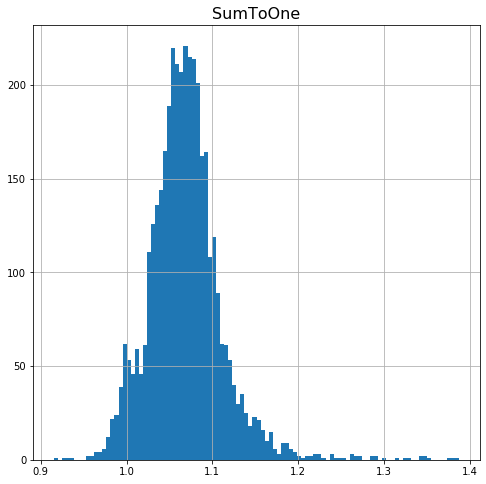

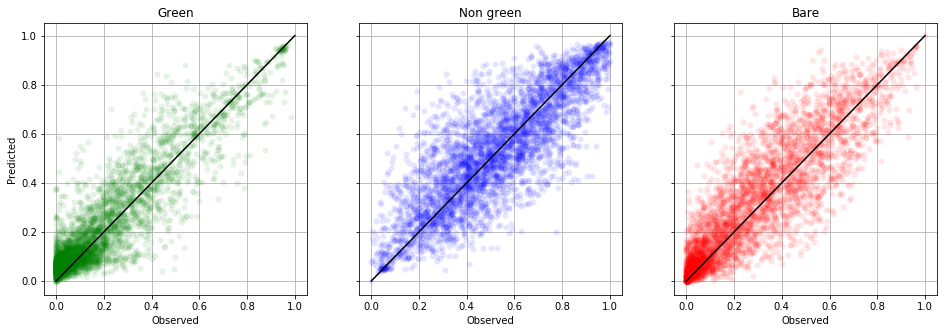

In [35]:
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,refData,greenWeights,nonGreenWeights,bareWeights,predGreenCover,predNongreenCover,predBareCover=dill.load(open('fcDump4.dat', "rb" ))

totalSum = predNongreenCover+predGreenCover+predBareCover
#predNongreenCover=predNongreenCover/totalSum
#predGreenCover=predGreenCover/totalSum
#predBareCover=predBareCover/totalSum
#totalSum = predNongreenCover+predGreenCover+predBareCover

# Setup the figure
fig = plt.figure(figsize=(8,8))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=16)
plt.grid(True)
plt.savefig('FCsum2one.png', bbox_inches='tight')

print( "Green RMSE = %f" % numpy.sqrt(numpy.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % numpy.sqrt(numpy.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % numpy.sqrt(numpy.mean((totalBareCover-predBareCover)**2)))


# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.1,markeredgewidth=0.0)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.1,markeredgewidth=0.0)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.1,markeredgewidth=0.0)
ax1.plot([0,1], [0,1],'k-')
ax2.plot([0,1], [0,1],'k-')
ax3.plot([0,1], [0,1],'k-')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_xlabel('Observed')
ax2.set_xlabel('Observed')
ax3.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
f.savefig('FCrecalibration.png', bbox_inches='tight')

## Assess the stability of the model by running cross validation
We use a 50:50 split run 

In [36]:
refDataGreen = numpy.copy(refData[:,:8]) 
greenEstimator.fit(refDataGreen, logit(totalPVCover))
resultsG = expit(greenEstimator.predict(refDataGreen))

refDataNonGreen = numpy.append(refDataGreen,numpy.transpose([resultsG]),axis=1)
nonGreenEstimator.fit(refDataNonGreen, logit(totalNPVCover))
resultsN = expit(nonGreenEstimator.predict(refDataNonGreen))

refDataBare = numpy.append(refDataNonGreen,numpy.transpose([resultsN]),axis=1)
bareEstimator.fit(refDataBare, logit(totalBareCover))



# TestTrainSplit
trainAmount = .5
iterations = 100

gdbMAD=numpy.zeros((3,iterations))
gdbRMS=numpy.zeros((3,iterations))
numSamples = len(refData)
trainNumber=int(trainAmount * numSamples)

for i in range(iterations):
    #print( iterations - i,)
    randIDX=numpy.random.permutation(range(numSamples))
    trainIDX = randIDX[:trainNumber]
    testIDX = randIDX[trainNumber:]

    greenEstimator.fit(refDataGreen[trainIDX], logit(totalPVCover[trainIDX]))
    resultsG = expit(greenEstimator.predict(refDataGreen[trainIDX]))
    resultsGTest = expit(greenEstimator.predict(refDataGreen[testIDX]))


    gdbMAD[0,i] = numpy.median(numpy.abs(resultsGTest - totalPVCover[testIDX]))
    gdbRMS[0,i] = numpy.sqrt(numpy.mean((resultsGTest - totalPVCover[testIDX])**2.0))

    refDataNonGreenTrain = numpy.append(refDataGreen[trainIDX],numpy.transpose([resultsG]),axis=1)
    refDataNonGreenTest = numpy.append(refDataGreen[testIDX],numpy.transpose([resultsGTest]),axis=1)


    nonGreenEstimator.fit(refDataNonGreenTrain, logit(totalNPVCover[trainIDX]))
    resultsN = expit(nonGreenEstimator.predict(refDataNonGreenTrain))
    resultsNTest = expit(nonGreenEstimator.predict(refDataNonGreenTest))


    gdbMAD[1,i] =  numpy.median(numpy.abs(resultsNTest - totalNPVCover[testIDX]))
    gdbRMS[1,i] = numpy.sqrt(numpy.mean((resultsNTest - totalNPVCover[testIDX])**2.0))

    refDataBareTrain = numpy.append(refDataNonGreen[trainIDX],numpy.transpose([resultsN]),axis=1)
    refDataBareTest = numpy.append(refDataNonGreen[testIDX],numpy.transpose([resultsNTest]),axis=1)


    bareEstimator.fit(refDataBareTrain, logit(totalBareCover[trainIDX]))
    resultsB = expit(bareEstimator.predict(refDataBareTrain))
    resultsBTest = expit(bareEstimator.predict(refDataBareTest))

    gdbMAD[2,i] = numpy.median(numpy.abs(resultsBTest - totalBareCover[testIDX]))
    gdbRMS[2,i] = numpy.sqrt(numpy.mean((resultsBTest - totalBareCover[testIDX])**2.0))






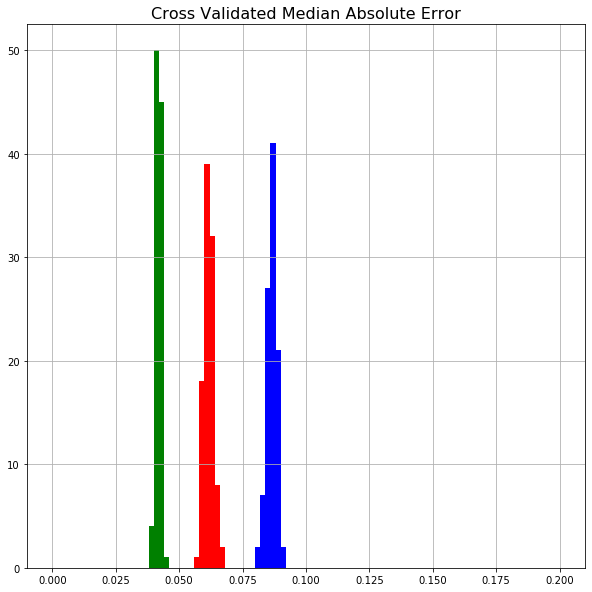

In [37]:
fig = plt.figure(figsize=(10,10))
plt.hist(gdbMAD[0], bins=100, color="green", range=(0.0,0.2) )
plt.hist(gdbMAD[1], bins=100, color="blue", range=(0.0,0.2) )
plt.hist(gdbMAD[2], bins=100, color="red", range=(0.0,0.2) )
plt.title('Cross Validated Median Absolute Error', fontsize=16)
plt.grid(True)
plt.savefig('madError.png', bbox_inches='tight')

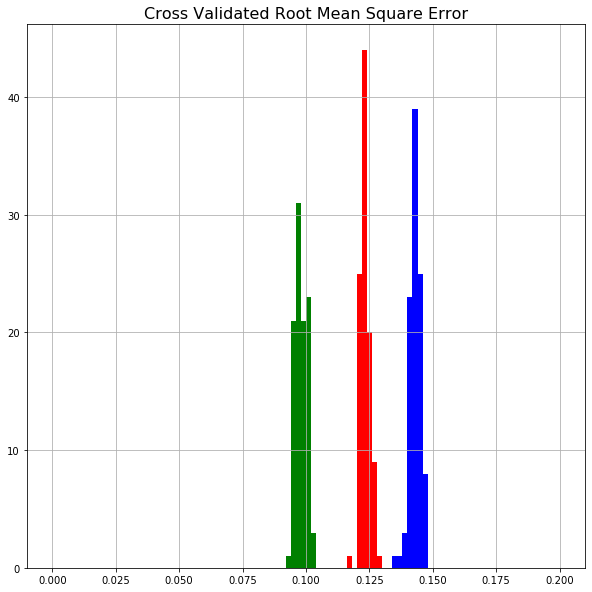

In [38]:
fig = plt.figure(figsize=(10,10))
plt.hist(gdbRMS[0], bins=100, color="green", range=(0.0,0.2))
plt.hist(gdbRMS[1], bins=100, color="blue", range=(0.0,0.2) )
plt.hist(gdbRMS[2], bins=100, color="red", range=(0.0,0.2) )
plt.title('Cross Validated Root Mean Square Error', fontsize=16)
plt.grid(True)
plt.savefig('rmsError.png', bbox_inches='tight')

## And check that the model runs!

In [39]:
from rios import applier
import numpy as np
import dill
#from sklearn.svm import SVR

# Logit transform adapted to account for 0 and 1
def logit(p):
    q = p * 0.98 + 0.01
    return np.log(q) - np.log(1 - q)

def expit(q):
    p =  np.exp(q) / (1 + np.exp(q))
    return (p - 0.01) / 0.98

def unmixfc(info,inputs,outputs):
    #Sentinel 2 nbar = inputs.nbar[[0,1,2,6,8,9]]
    nbar = inputs.nbar
    # Get the shape of the input array
    inshape = nbar.shape
    # Flatten and floating point reflectance
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0
    # Convert Landsat 8
    #nbar = np.transpose(np.transpose(nbar) * np.array([0.95852,0.98911,0.99291,0.93819,0.98824,0.97591]) + np.array([0.00501,0.00307,0.00198,0.00087,0.00141,-0.00147]))
    # Convert Sentinel 2
    #nbar = np.transpose(np.transpose(nbar) * np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]))
    # Compute Indicies
    ndvi = (nbar[3]-nbar[2])/(nbar[3]+nbar[2] + np.finfo('float32').eps)
    burn = (nbar[3]-nbar[5])/(nbar[3]+nbar[5] + np.finfo('float32').eps)
    ndwi = (nbar[3]-nbar[4])/(nbar[3]+nbar[4] + np.finfo('float32').eps)
    
    # Compute Green
    refDataGreen = np.transpose(np.append(nbar[1:],[ndvi,burn,ndwi],axis=0))
    green = expit(greenEstimator.predict(refDataGreen))
    # Compute non-green
    refDataNonGreen = np.append(refDataGreen,np.transpose([green]),axis=1)
    nongreen = expit(nonGreenEstimator.predict(refDataNonGreen))
    # Compute Bare
    refDataBare = np.append(refDataNonGreen,np.transpose([nongreen]),axis=1)
    bare = expit(bareEstimator.predict(refDataBare))
    # Scale Fractions
    totalSum = bare + green + nongreen + np.finfo('float32').eps
    # Scale Output
    outputFC = np.round(100 + 100 * np.array([bare,green,nongreen]) / totalSum,0)
    # Correct noData
    outputFC[:,nbar[0] < 0.001] = 0
    # Mask NDVI Threshold
    #outputFC[:,ndvi < 0.06] = 0
    # Mask Bright Threshold
    #outputFC[:,nbar.min(axis=0) > 0.24] = 0
    # Mask Poor Sum2One
    #outputFC[:,totalSum < 0.90] = 0
    #outputFC[:,totalSum > 1.10] = 0
    outputFC = np.reshape(outputFC,(3,inshape[1],inshape[2]))
    # Write the FC Output
    outputs.fc =  outputFC.astype(np.uint8)

      
# Import the SVR pipelines
with open('svmPipelines', 'rb') as input:
    (greenEstimator,nonGreenEstimator,bareEstimator) = dill.load(input)


#RIOS
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()

infiles.nbar = '/home/jovyan/work/Temp/fcTest/lztmre_sa_m200703200705_dbia2.tif'
outfiles.fc = '/home/jovyan/work/Temp/fcTest/lztmre_sa_m200703200705_FC3a2.tif'

controls = applier.ApplierControls()
controls.setNumThreads(4)
controls.setJobManagerType('multiprocessing')
controls.windowxsize = 512
controls.windowysize = 512
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE","ZLEVEL=9","BIGTIFF=YES","TILED=YES","INTERLEAVE=BAND","NUM_THREADS=ALL_CPUS"])

applier.apply(unmixfc, infiles, outfiles, controls=controls)



Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/site-packages/rios/parallel/jobmanager.py", line 742, in multiUserFunc
    userFunc(*params)
  File "<ipython-input-39-ca4bb4ad14da>", line 33, in unmixfc
    green = expit(greenEstimator.predict(refDataGreen))
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py", line 324, in predict
    return predict(X)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py", line 346, in _dense_predict
    cache_size=self.cache_size)
KeyboardInterrupt


KeyboardInterrupt: 

Process ForkPoolWorker-16:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/site-packages/rios/parallel/jobmanager.py", line 742, in multiUserFunc
    userFunc(*params)
  File "<ipython-input-39-ca4bb4ad14da>", line 33, in unmixfc
    green = expit(greenEstimator.predict(refDataGreen))
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py", line 324, in predict
    return predict(X)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py", line 346, in _dense_predict
    cache_size=self.cache_size)
KeyboardInterrupt
Process ForkPoolWorker-17:
Traceback (most recent call last):
  File "/opt/conda/lib/pytho

## Crypto Analysis

In [ ]:
cryptoPipeline = grid_search.best_estimator_


# TestTrainSplit
trainAmount = .5
iterations = 1000

gdbMAD=numpy.zeros(iterations)
gdbRMS=numpy.zeros(iterations)
gdbR2=numpy.zeros(iterations)
numSamples = len(refDataCrypto)
trainNumber=int(trainAmount * numSamples)

for i in range(iterations):
    randIDX=numpy.random.permutation(range(numSamples))
    trainIDX = randIDX[:trainNumber]
    testIDX = randIDX[trainNumber:]

    cryptoPipeline.fit(refCrypto[trainIDX], logit(siteCrypto[trainIDX]))
    resultsC = expit(cryptoPipeline.predict(refCrypto[trainIDX]))
    resultsCTest = expit(cryptoPipeline.predict(refCrypto[testIDX]))


    gdbMAD[i] = numpy.median(numpy.abs(resultsCTest - siteCrypto[testIDX]))
    gdbRMS[i] = numpy.sqrt(numpy.mean((resultsCTest - siteCrypto[testIDX])**2.0))
    gdbR2[i] = stats.pearsonr(resultsCTest,siteCrypto[testIDX])[0]


fig = plt.figure(figsize=(10,10))
plt.hist(gdbR2, bins=50, color="green", range=(0.0,0.5))
plt.title('Cross Validated R2', fontsize=16)
plt.grid(True)
